## High-dynamic range imaging - The Debevec-Malik method
#### April Li, Mesha Naidoo-Edwardson
#### s826li@uwaterloo.ca, mnaidooe@uwaterloo.ca

The goal of this project is to implement the high-dynamic range imaging (HDRI). HDRI is a method in photography that combines multiple exposures of the same subject matter with varying exposure levels to create more natural looking and brightened images. HDRI as a topic has several different algorithms. In this project, we will utilize the Debevec-Malik algorithm, published at UC Berekeley by Paul E. Debevec and Jitendra Malik.

The algorithm is a method to recover high dynamic range radiance maps from images taken using convential imaging equipment. Using information from all the images, it fuses multiple photographs into a signle, high dynamic range radiance map. The pixels in the map have values proportional to true radiance values in the scene.

As a follow up to implementing the HDRI algorithm, we will use RANSAC for homographies to eliminate the need for a tripod. We will use the RANSAC method for homographies to project all images onto a common plane and use HDRI in order to get a high-resolution aligned image.

Our goal is to separate the algorithm into easily digestable steps that make it simple to understand how the results are achieved.

## Team Members and Contributions
April Li (s826li@uwaterloo.ca): Implemented RANSAC and Homography Estimation. Added GPU usage to increase speed of program. Compared before and after results of alignment.

Mesha Naidoo-Edwardson (mnaidooe@uwaterloo.ca): Built HDRI algorithm through Debevec's research papers. Wrote up explanations and formatting.

### Code Libraries
- Numpy: Providing mathematical capabilities in python
- matplotlib.pyplot: Helpful graphing features
- matplotlib.image: Import images
- os: Access files
- random: Helping with sampling
- Cupy: Using GPU to speed up Image processing
- Skimage: Helping with Image processing/alignment
- math: for calculations using math functions

In [ ]:
%matplotlib inline

import numpy as np
from numpy import linalg as la
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import os
import random
import cupy as cp
import math

from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

### Step 1

### Importing Images and Data, declare Constants
The first step in our process is to the exposure times. These images are to have been taken from the same vantage point, and have different **known** exposure durations $\delta t_j$. The images will be loaded as 3-channel RGB values. For now this information isn't too important, but we will remember this down the line as we will need to run our computations on each of the channels to obtain our final result.

The following code doesn't relate directly to the algorithm and is a preprocessing step. Here we access the files in local directory to get the images and exposure times.

In order to use this project, there should be a directory named {image} with all the images inside named {image}{0...} and {image}.txt which contains exposure times, one per line, in a format x/y representing the shutter speed.

In [ ]:
# Load into an array of images (4D)
def load_images(path):
    images = []

    for file in sorted(os.listdir(path)):
        if file.startswith(path) and (file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg')):
            image_path = os.path.join(path, file)
            img = image.imread(image_path)
            images.append(img)
    return np.stack(images)

# Load into a 1D array of exposure times
def load_exposure_times(path):
    file_path = f'{path}/{path}.txt'
    with open(file_path, 'r') as f:
        exposure_times_str = f.readlines()

    # Convert the exposure time strings to numerical values
    exposure_times = []
    for time_str in exposure_times_str:
        # Assuming the format is "1/xxx"
        numerator, denominator = time_str.strip().split('/')
        exposure_times.append(float(numerator) / float(denominator))

    return np.array(exposure_times)

Here we load our data. We will use two sets of images. The first, memorial, comes directly from [Debevec's website](https://www.pauldebevec.com/Research/HDR/SourceImages/Memorial_SourceImages.zip). The second is a photo of a flower pot from a local coffee shop, Seven Shores, that were taken by April. The second set will be used when we talk about aligning the image and eliminating the need for a tripod.

In [ ]:
PATH1 = "memorial"
PATH2 = "flower"

images = load_images(PATH1)
images_pt2 = load_images(PATH2)

im_height_pt2, im_width_pt2 = images_pt2[0].shape[:2]

exposure_times = load_exposure_times(PATH1)
exposure_times_pt2 = load_exposure_times(PATH2)


Unfortunately, in Debevec's sample data there is some issue with dead blue pixels showing up. For this set of images, we will cut out these pixels to remove the outlier points. Example shown below, as well as a loop to cut out these dead pixels.

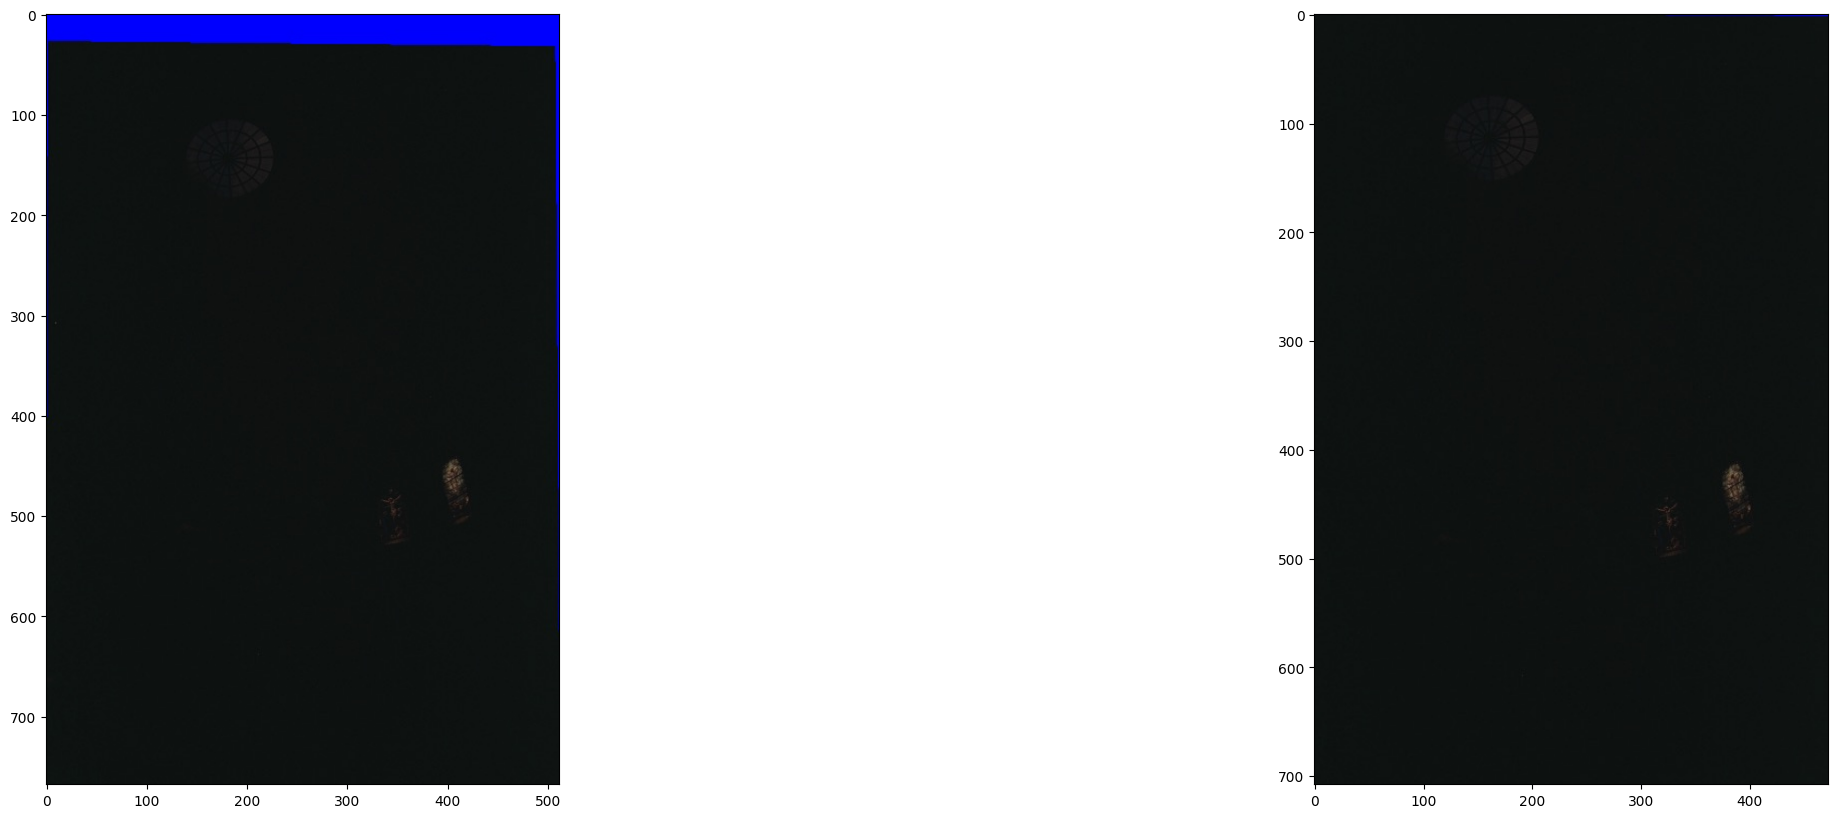

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(30, 10))
axs[0].imshow(images[0])
axs[1].imshow(images[0][30:-30, 20:-20, :])

images_pt1 = np.empty((len(images), 708, 472, 3), dtype=np.uint8)

for i in range(len(images)):
  images_pt1[i] = images[i][30:-30, 20:-20, :]

im_height, im_width = images_pt1[0].shape[:2]



We are using GPU to greatly improve the performance. Change variable _USE_GPU_ to select if we are computing with GPU or not.

In [ ]:
USE_GPU = True
xp = cp if USE_GPU else np

## The Algorithm

### Sampling
The first step of the HDRI algorithm involves taking samples of intensity values. In order to solve , we don't need to use every available pixel site in the solution procedure. Given $N$ pixels in $P$ photographs, our goal is solving for $N$ values of $\ln E_i$ and $Z_{max} - Z_{min}$ (where max is 255 and min is 0 representing range of pixel values). In order to create ourselves a system that is overdetermined and thus solveable, we need that $N(P-1) > (Z_{max}-Z_{min}) = 255$.

The takeaway from all of this would be that the time complexity of this algorithm would blow up if we used all pixels in place of sampling. Thus, we sample enough pixels to solve our problem while reducing runtime.

In [ ]:
def sampleIntensities(images):
    xp = cp if USE_GPU else np  # Choose the library based on USE_GPU flag

    zMin, zMax = 0, 255
    n = zMax - zMin + 1
    num_images = len(images)

    # Convert images to CuPy arrays if USE_GPU is True
    if USE_GPU:
        images = [cp.array(image) for image in images]

    values = xp.zeros((n, num_images), dtype=xp.uint8)
    mid = images[num_images // 2]

    for i in range(zMin, zMax + 1):
        rows, cols = xp.where(mid == i)
        if rows.size > 0:
            # Use CuPy or NumPy specific random functions
            idx = xp.random.randint(0, rows.size) if USE_GPU else random.randrange(rows.size)
            sampled_values = xp.array([img[rows[idx], cols[idx]] for img in images], dtype=xp.uint8)
            values[i] = sampled_values

    # Convert values back to NumPy array if using GPU
    if USE_GPU:
        values = cp.asnumpy(values)

    return values


### Weighting Function
In order to emphasize the smoothness and fitting terms toward the middle of the curve, Debevec defines the following weighting function:

$$w(z) =
\begin{cases}
    z - Z_{min}\quad \text{for } z \leq \frac{1}{2}(Z_{min} + Z_{max})\\
    Z_{max} - z\quad \text{for } z > \frac{1}{2}(Z_{min} + Z_{max})\\
\end{cases}$$

$Z_{min}$ and $Z_{max}$ are as defined above in our case. This function is used in both our `gSolve` function, which calculates the imaging system's response function, as well as in our `computeRadianceMap`, which as the name suggests performs the computation of our later talked about radiance map.


In [ ]:
def w(z):
    zMin, zMax = 0., 255.
    # Ensure z is an array for vectorized operations
    z = xp.asarray(z)
    return xp.where(z <= (zMin + zMax) / 2, z - zMin, zMax - z)

### gSolve
As mentioned in the weighting function, our gSolve function is the next step in our HDRI process. This function tackles solving one of the big challenges in this algorithm, which is solving the linear system that minimizes the following function:

$$\mathbf{O} = \sum_{i=1}^N\sum_{j=1}^P[g(Z_{ij})-\ln E_i - \lnΔt_j]^2+λ∑_{z=Z_{min}+1}^{Z_{max}-1}g''(z)^2$$

This function looks quite scary at first. The second and less confusing term is a smoothness term that essentially ensures our function $g$ is smooth. Well, the next thought is what is $g$?

$$g = \ln f^{-1}$$

where $f$ is some nonlinear function of the original exposure $X$ at a pixel $Z$. Then,

$$g(Z_{ij}) = \ln E_i + \lnΔt_j$$

is a seat of equations, where $Z_{ij}$ is a single pixel value, $Δt$ represents our shutter speed at image $j$, and $E$ is our irradiance term.

The first term of the equation is the beefy solving of least squares for our $g(Z_ij)$, and all this is aimed to create a smooth response function.

In [ ]:
def gSolve(Z, B, l=100, w=w):
    n = 256
    m = Z.shape[0] * Z.shape[1] + n + 1
    A = np.zeros((m, n + Z.shape[0]))
    b = np.zeros((m, 1))

    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            zij = Z[i, j]
            wij = w(zij)
            A[k, zij] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[j]
            k += 1

    A[k, 128] = 1
    k += 1

    for i in range(n - 2):
        A[k, i] = l * w(i + 1)
        A[k, i + 1] = -2 * l * w(i + 1)
        A[k, i + 2] = l * w(i + 1)
        k += 1

    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[:n]
    lE = x[n:n + Z.shape[0]]

    return g, lE

### Radiance Map
Once we have computed our response function, we then move to computing the radiance map. The radiance map for each channel (R, G, B) will be combined into one final product that will create our coloured HDRI image. In order to compute, we calculate $$\ln E_i = \frac{∑_{j=1}^P w(Z_{ij})(g(Z_{ij})-\lnΔt_j)}{∑_{j=1}^Pw(Z_{ij})}$$

The goal here is that combining multiple exposures will reduce noise in the image, alongside that our weighting function will ignore saturated pixels. This helps to build the best possible final result.


In [ ]:
%%time

def computeRadianceMap(images, log_exposure_times, response_curve, weighting_function=w):
    num_images = len(images)
    img_shape = images[0].shape

    # Convert to CuPy arrays if using GPU
    if USE_GPU:
        images = cp.array(images)
        log_exposure_times = cp.array(log_exposure_times)
        response_curve = cp.array(response_curve)
        xp = cp  # CuPy namespace
    else:
        xp = np  # NumPy namespace

    response = response_curve[images]

    weights = weighting_function(images)[..., np.newaxis]
    sum_weights = xp.sum(weights, axis=0)

    # Avoid division by zero
    sum_weights[sum_weights == 0] = 1
    log_exposure_times_reshaped = log_exposure_times.reshape(num_images, 1, 1, 1)

    img_rad_map = xp.sum(weights * (response - log_exposure_times_reshaped), axis=0) / sum_weights

    # Handle zero weights
    zero_weights_mask = sum_weights == 1
    median_response = response[num_images // 2]
    img_rad_map[zero_weights_mask] = median_response[zero_weights_mask] - log_exposure_times[num_images // 2]

    # Convert back to NumPy array if using GPU
    if USE_GPU:
        img_rad_map = cp.asnumpy(img_rad_map)

    return img_rad_map


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


### Putting it all together
Here we have the HDRI function that puts everything together. We first grab each channel (R,G,B) and sample them. We then calculate the logExposures from the known exposure times as this is what we use for computations is `gSolve` and `computeRadianceMap`.

The next step as described above is to gSolve each channel, compute a radiance map, and rebuild the image. In order to get smoother values, we normalize each channel before merging them together.

In [ ]:
def hdri(images, exposure_times):
  # Select each of the three colour channels (RGB)
  R = images[:,:,:,0]
  G = images[:,:,:,1]
  B = images[:,:,:,2]

  # Randomly sample intensities from these channels
  sampleRed = sampleIntensities(R)
  sampleGreen = sampleIntensities(G)
  sampleBlue = sampleIntensities(B)

  # Calculate the logarithm of the exposure times
  logExposures = np.log(exposure_times)

  # Solve the least-squares equation
  gr, _ = gSolve(sampleRed, logExposures)
  gg, _ = gSolve(sampleGreen, logExposures)
  gb, _ = gSolve(sampleBlue, logExposures)

  # Compute Radiance Map for each of our channels
  mapR = computeRadianceMap(R, logExposures, gr)
  mapG = computeRadianceMap(G, logExposures, gg)
  mapB = computeRadianceMap(B, logExposures, gb)

  hdr_image = np.zeros(images[0].shape, dtype=int)

  # Normalize the values in our maps
  mn, mx = mapR.min(), mapR.max()
  normalized_mapR = (((mapR - mn) * 256) / (mx - mn)).astype(np.uint8)

  mn, mx= mapG.min(), mapG.max()
  normalized_mapG = (((mapG - mn) * 256) / (mx - mn)).astype(np.uint8)

  mn, mx = mapB.min(), mapB.max()
  normalized_mapB = (((mapB - mn) * 256) / (mx - mn)).astype(np.uint8)

  # Combine back into one HDR image
  hdr_image[..., 0] = normalized_mapR[:, :, 0]
  hdr_image[..., 1] = normalized_mapG[:, :, 0]
  hdr_image[..., 2] = normalized_mapB[:, :, 0]

  return (gr, gg, gb), (mapR, mapG, mapB), hdr_image

## Results
Let's now examine the results of our function. First, we can look at the response curves. The response curves are meant to be monotically increasing. As mentioned above, we recover the response curve in order to use it to compute the radiance maps. We can see below that as desired our response curves for each channel increase.

In [ ]:
(gr, gg, gb), (mapR, mapG, mapB), hdr_image = hdri(images_pt1, exposure_times)

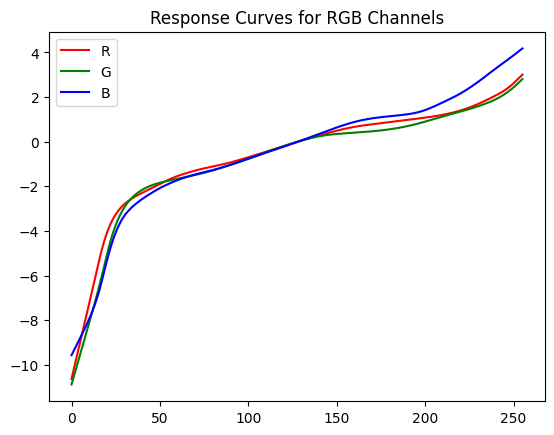

In [ ]:
plt.title("Response Curves for RGB Channels")
plt.plot(gr, color="red", label="R")
plt.plot(gg, color="green", label="G")
plt.plot(gb, color="blue", label="B")
plt.legend()

The radiance maps show the strength of each pixel at a specific point. You can compare the details in each of the maps to see which pixels contain strong values of each.

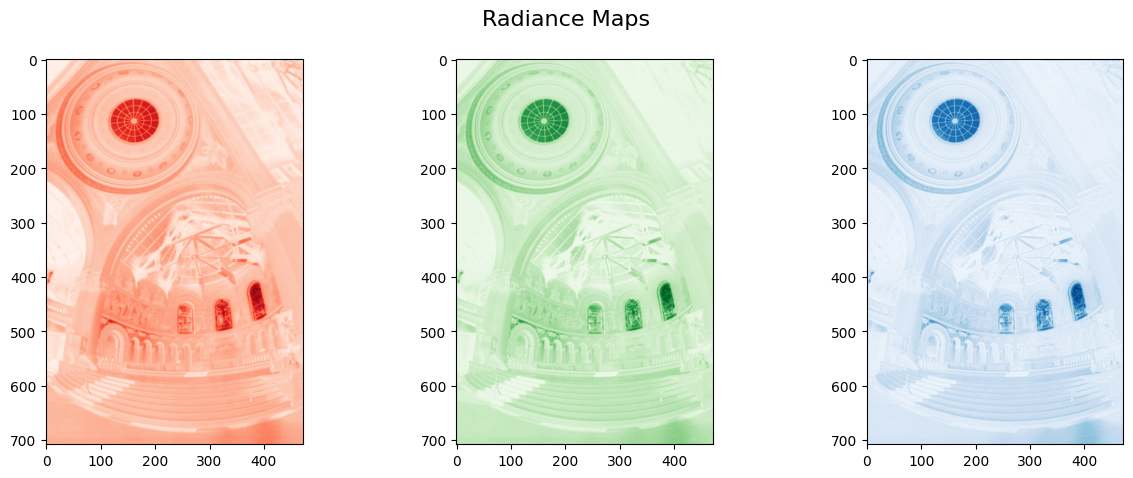

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Radiance Maps", fontsize=16)
axs[0].imshow(mapR, cmap="Reds")
axs[1].imshow(mapG, cmap="Greens")
axs[2].imshow(mapB, cmap="Blues")

Below are the results of HDRI on a camera that was stable. We see the end result above the 6 images that went into it. It is clear to see that we recovered an image with much clearer vision and colours than we saw in the original photos used to create it.

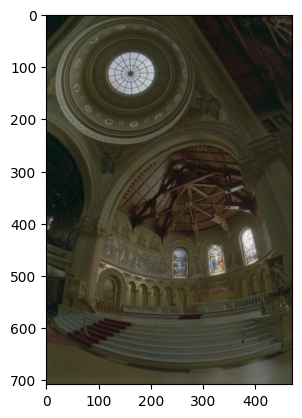

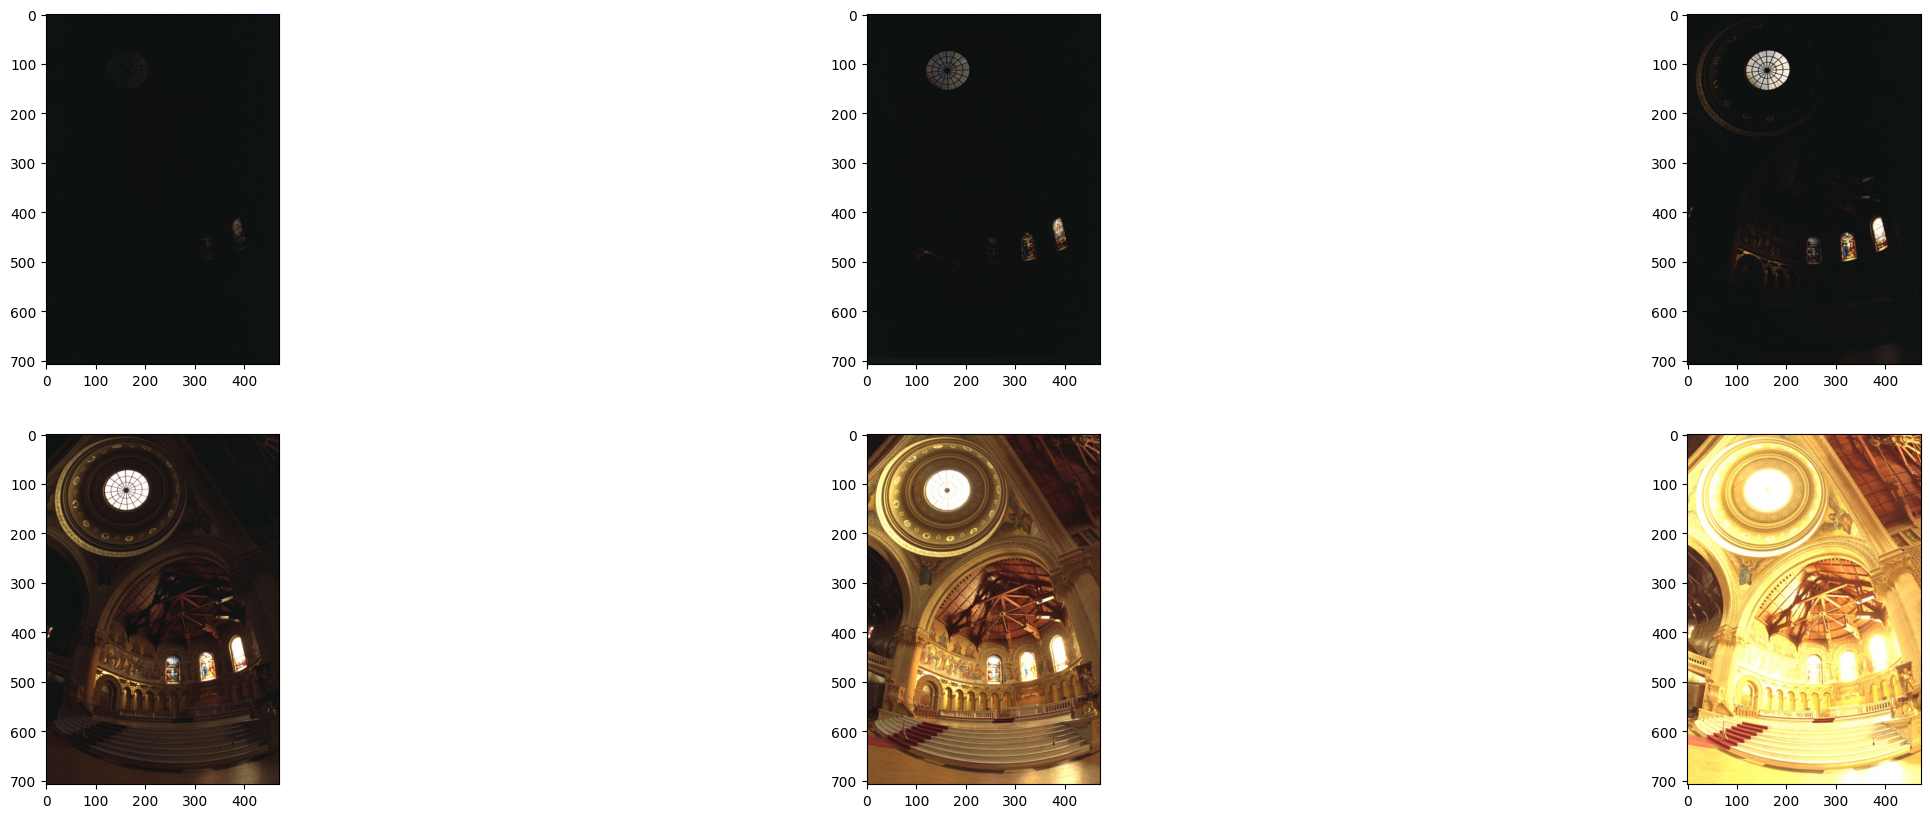

In [ ]:
# Displaying results
plt.imshow(hdr_image)
fig, axs = plt.subplots(2, 3, figsize=(30, 10))
axs[0][0].imshow(images_pt1[0])
axs[0][1].imshow(images_pt1[1])
axs[0][2].imshow(images_pt1[2])
axs[1][0].imshow(images_pt1[3])
axs[1][1].imshow(images_pt1[4])
axs[1][2].imshow(images_pt1[5])

## Continued: Preprocessing Image for better result

Let's take a look at the HDRI algorithm ran on images that aren't well aligned. First here are the original pictures:

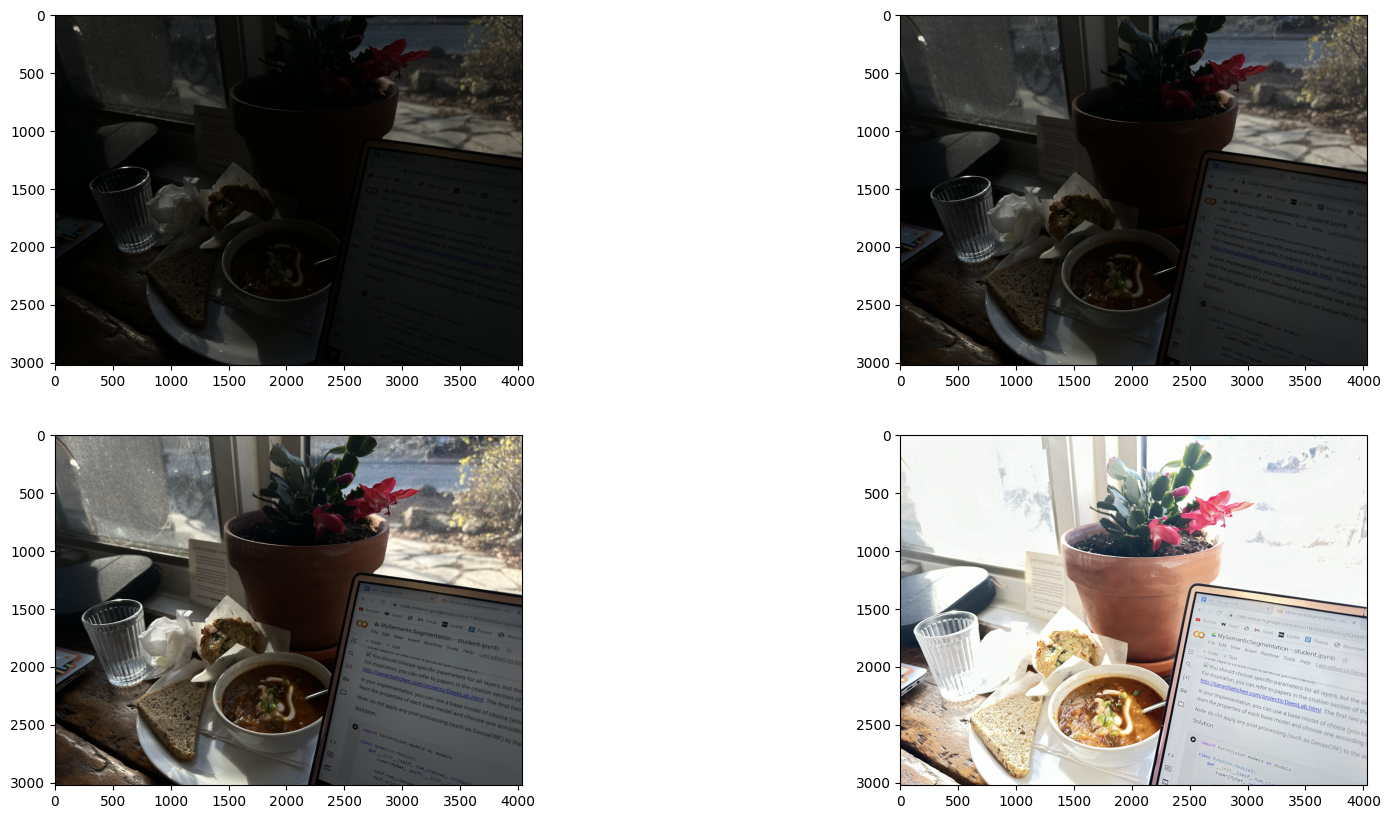

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0][0].imshow(images_pt2[0])
axs[0][1].imshow(images_pt2[1])
axs[1][0].imshow(images_pt2[2])
axs[1][1].imshow(images_pt2[3])

Now, lets see the result of running HDRI when they don't properly align. Clearly, the image has a sense of motion blur. We are combining pixels that don't properly line up, and the result is a poor photo.

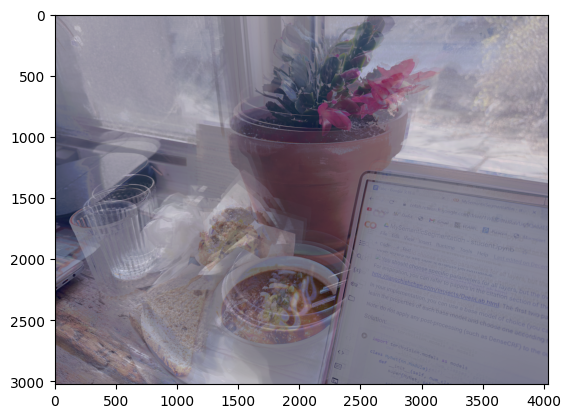

In [ ]:
(gr, gg, gb), (mapR, mapG, mapB), hdr_image = hdri(images_pt2, exposure_times_pt2)
plt.imshow(hdr_image)

If we take a look at the response functions, we notice that they are not very smooth either. How can we fix this? Enter RANSAC and Homographies.

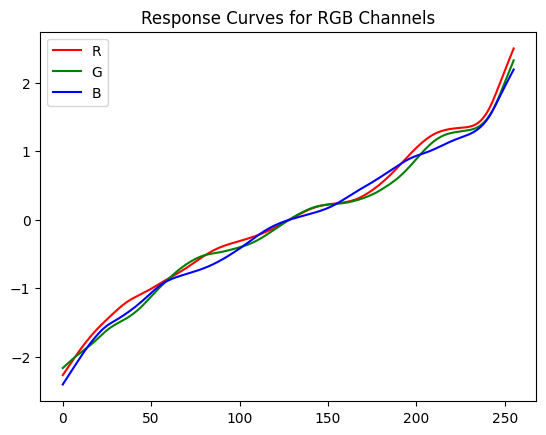

In [ ]:
plt.title("Response Curves for RGB Channels")
plt.plot(gr, color="red", label="R")
plt.plot(gg, color="green", label="G")
plt.plot(gb, color="blue", label="B")
plt.legend()

The radiance maps also showcase that same motion blur seen in the final result. We can see the values of pixels across RGB spectrum appear to be much more dispersed rather than having fine edges.

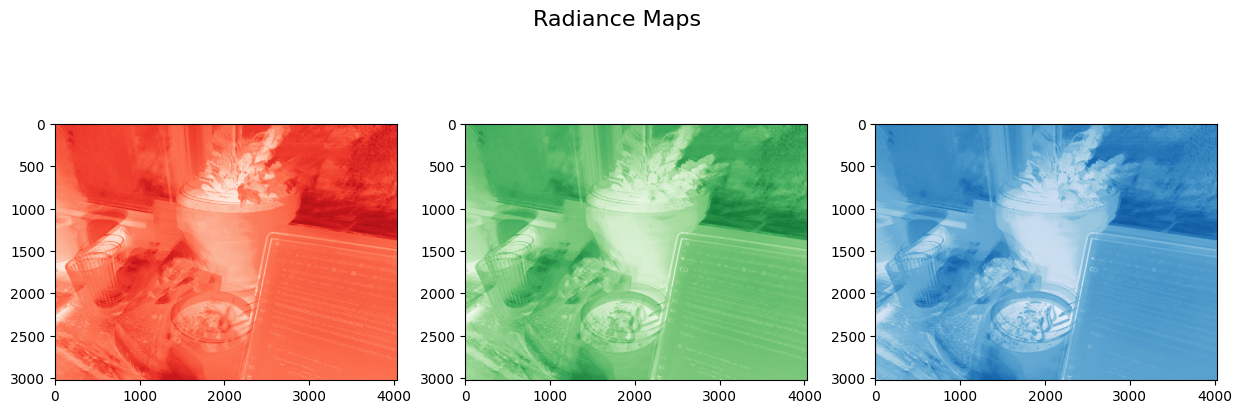

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Radiance Maps", fontsize=16)
axs[0].imshow(mapR, cmap="Reds")
axs[1].imshow(mapG, cmap="Greens")
axs[2].imshow(mapB, cmap="Blues")

####Image alignment with RANSAC

We see that previously, the result is appearing to be blurry since the images are not exactly aligned. Before we start image recovery, we want to use RANSAC to align the images, since sometimes recovered results could be blurry due to images not taken with a tripod. This RANSAC preprocessing used is referencing part 2 of Assignment 1.

Side note: Here is a small performance bottleneck since the library skImage relies highly on traditional Numpy, functions like _corner_peak_, _ransac_, or _warp_ cannot be run with GPU.

#### Feature Detact Match
Given left(reference image) and right image, this function below demonstrates feature detection and matching and return for estimating homography later.

In [ ]:
def feature_detact_match(imL, imR):
  imLgray = rgb2gray(imL)
  imRgray = rgb2gray(imR)

  # NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
  keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
  keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

  extractor = BRIEF()

  extractor.extract(imLgray, keypointsL)
  keypointsL = keypointsL[extractor.mask]
  descriptorsL = extractor.descriptors

  extractor.extract(imRgray, keypointsR)
  keypointsR = keypointsR[extractor.mask]
  descriptorsR = extractor.descriptors

  matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

  return keypointsL, keypointsR, matchesLR


#### RANSAC Estimate


This function below uses RANSAC to estimate Homography from matched pairs of points given.


In [ ]:
def RANSAC_estimate(keypointsL, keypointsR, matchesLR):
  N = 53
  Ni = 21

  P = (Ni*(Ni-1)*(Ni-2)*(Ni-3))/(N*(N-1)*(N-2)*(N-3))
  n = math.ceil(math.log(0.05) / math.log(1 - P))

  L = keypointsL[matchesLR[:,0]]
  R = keypointsR[matchesLR[:,1]]

  return ransac((L,R), model_class=ProjectiveTransform, min_samples=4, residual_threshold = 4, max_trials=n)

#### Warp and Reprojection

The function _reprojection_ below uses common principal points corresponding to the plane of the left image. The pamorama mosaic is built inside a "reference frame" inside this common PP. The reference frame is set to be original image's width and height since we want the result to be aligned without changing size of the image.

In [ ]:
def warp_helper(img, model):
    return np.swapaxes(warp(np.swapaxes(img, 0, 1), model, output_shape=(im_width_pt2, im_height_pt2)), 0, 1)

def reprojection(imL, imR, modelL, model):
    transformedL = warp_helper(imL, modelL)
    transformedR = warp_helper(imR, model)

    return transformedL, transformedR

#### Blending

The function _boundaryDT_ computes distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values).

The function _get_alpha_ is a helper function that finds and returns smooth  alpha's suitable for blending the left and right images.

The function _blending_ uses boundary distance transforms to blend left and right images (reprojected) into the reference frame, then return transformed left and right image.

In [ ]:
def blending(imL, imR, modelL, model, transformedL, transformedR):
  def boundaryDT(image):
    # Throw away the last dimension
    R, C, _ = image.shape
    cols = np.arange(C)
    rows = np.arange(R).reshape((-1, 1))

    dL = cols
    dR = C - 1 - cols
    dU = rows
    dD = R - 1 - rows

    return np.minimum(np.minimum(dL, dR), np.minimum(dU, dD))

  dtL = warp_helper(boundaryDT(imL), modelL)
  dtR = warp_helper(boundaryDT(imR), model)

  def get_alpha(d1, d2):
    sum = d1 + d2

    # If sum is 0, set to small num to avoid div by 0
    sum[sum == 0] = 10 ** -10

    return d1/sum , d2/sum

  alphaL, alphaR = get_alpha(dtL, dtR)

  alphaImgL = transformedL*alphaL.reshape((alphaL.shape[0], alphaL.shape[1], 1))
  alphaImgR = transformedR*alphaR.reshape((alphaR.shape[0], alphaR.shape[1], 1))

  return alphaImgL, alphaImgR

#### Image input and alignment

we first load the raw images from given path into an np stack with _load_images_, note that we are using the left image as the reference image and projectioning right image onto it. We pick the middle image as the reference/left image every time, as we are assuming the images are given with exposure sets from lowest to highest, therefore, using the middle image as the reference would not make the aligned image to all appear too dark or bright due to preprocessing.

Then the function _img_alignment_ uses helper functions defined above to process/alignment each image and store result back into an np stack of image for recovery.

In [ ]:
%%time
middle_img_idx = math.floor(len(images_pt2)/2)

def img_alignment(images):
  res = []
  for i in range(len(images)):
    # reference image
    imL = images[middle_img_idx]
    imR = images[i]

    keypointsL, keypointsR, matchesLR = feature_detact_match(imL, imR)

    model, inliers = RANSAC_estimate(keypointsL, keypointsR, matchesLR)
    # Keep imL as is
    modelL = ProjectiveTransform(matrix=np.eye(3, 3))

    transformedL, transformedR = reprojection(imL, imR, modelL, model)
    alphaImgL, alphaImgR = blending(imL, imR, modelL, model, transformedL, transformedR)

    res.append(((alphaImgL + alphaImgR) * 255).astype(np.uint8))

  return (imL, imR, keypointsL, keypointsR, matchesLR, inliers), np.stack(res)

(imL, imR, keypointsL, keypointsR, matchesLR, inliers), aligned_images = img_alignment(images_pt2)

CPU times: user 53.5 s, sys: 12.1 s, total: 1min 5s
Wall time: 1min 4s


Displaying processing result for last image of the image list.

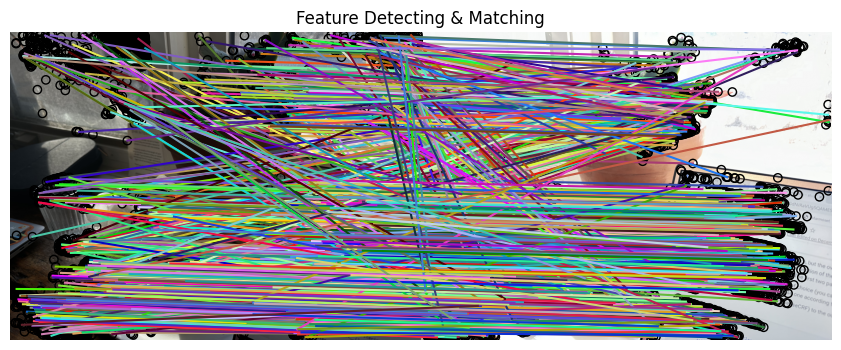

In [ ]:
fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')
plt.title("Feature Detecting & Matching")
plt.show()

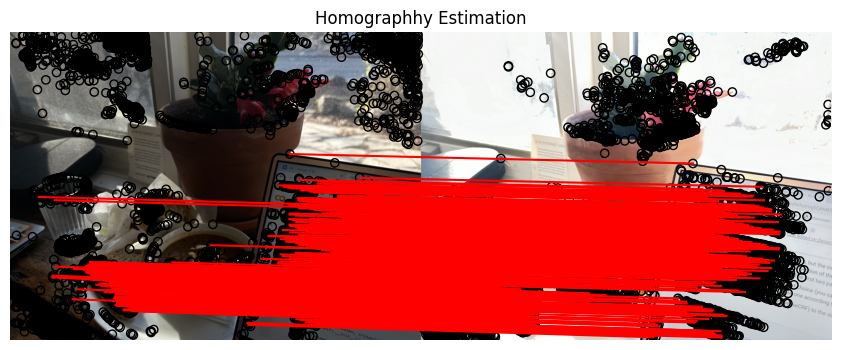

In [ ]:
fig = plt.figure(2,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR[inliers], matches_color = 'r')
axA.axis('off')
plt.title("Homographhy Estimation")
plt.show()

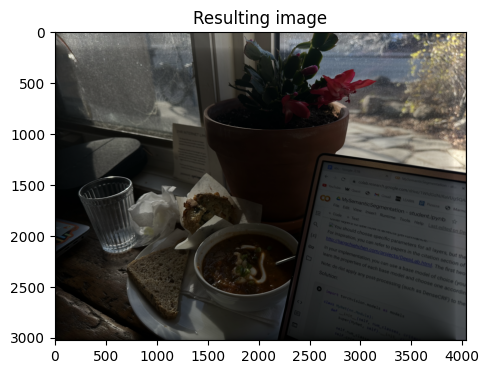

In [ ]:
fig = plt.figure(3,figsize = (12, 4))
plt.subplot(111)
plt.imshow(aligned_images[0])
plt.title("Resulting image")
plt.show()

### Alignment Results
Let's see the results!

In [ ]:
(gr, gg, gb), (mapR, mapG, mapB), hdr_image = hdri(aligned_images, exposure_times_pt2)

Our response curve is night and day difference from betfore. The values line up much closer, it is a true monotonic increasing function, and it is much smoother than before.

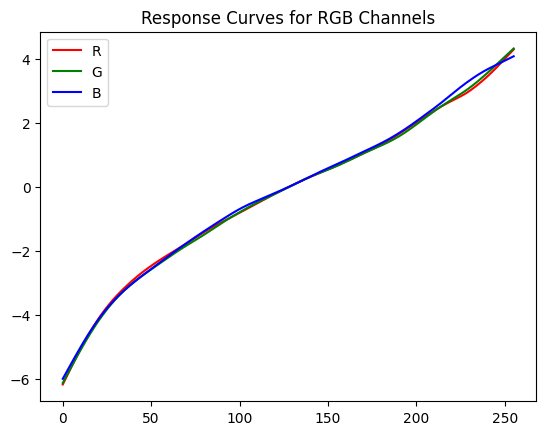

In [ ]:
plt.title("Response Curves for RGB Channels")
plt.plot(gr, color="red", label="R")
plt.plot(gg, color="green", label="G")
plt.plot(gb, color="blue", label="B")
plt.legend()

Similarly, our radiance maps have much more defined edges now and less blurring.

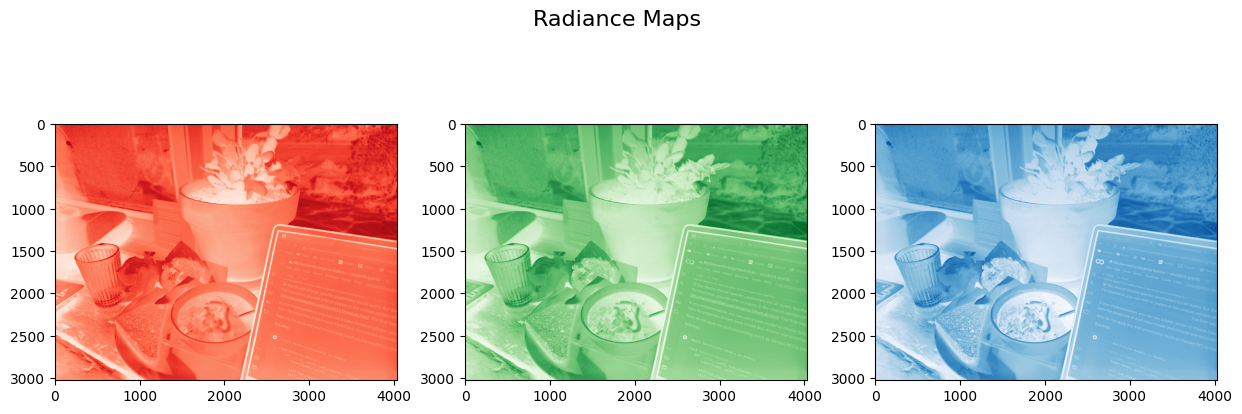

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Radiance Maps", fontsize=16)
axs[0].imshow(mapR, cmap="Reds")
axs[1].imshow(mapG, cmap="Greens")
axs[2].imshow(mapB, cmap="Blues")

Given the response function and radiance map, it is no surprise that our final image looks perfectly clear, has the right brightness, alignment, and show some delicious soup from Seven Shores cafe in Waterloo!

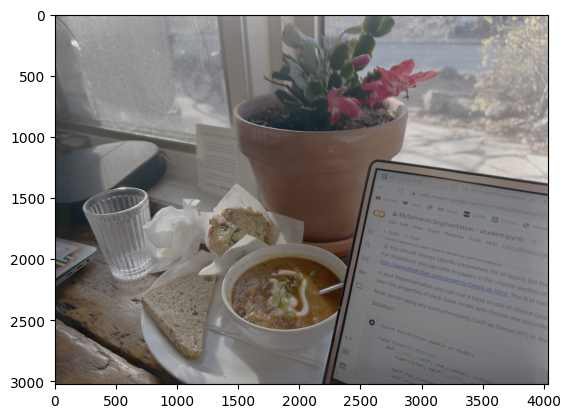

In [ ]:
plt.imshow(hdr_image)

### Conclusions
In conclusion, we see that the HDRI algorithm proposed by Debevec and Malik is an effective strategy to blend varying exposure images into one great image.

We saw in the first section what the details of the algorithm are, which includes:
- The math behind computing a response function
- How to use the response function and exposure times to compute a radiance map
- How we can normalize said radiance maps
- The role and implementation of the weighting function

All of these pieces together allowed us to convert seemingly awful photos into one desirable high-range image.

Following these results, we decided to look beyond still-images that were tripod taken. We introduced a variable of human movement, by taking photos with a hand-held cell phone at a cafe. When we ran the HDRI image on this original set of photos, it was unable to produce a high quality image due to the misalignment of pixels. After using RANSAC to sample and homographies to combine all these pictures with one alignment, we saw amazing results of a well-aligned and ranged image.

### Citations
Debevec, Paul, and Jitendra Malik. "Recovering High Dynamic Range Radiance Maps from Photographs." Proceedings of the 24th Annual Conference on Computer Graphics and Interactive Techniques, SIGGRAPH '97, 1997, pp. 369-378. ACM Press/Addison-Wesley Publishing Co., https://www.pauldebevec.com/Research/HDR/debevec-siggraph97.pdf.

Photos from https://www.pauldebevec.com/Research/HDR/SourceImages/Memorial_SourceImages.zip
